# Zonal Temperature Bias
 
 Note that:
 * 1degree case uses a slightly different WOA13 database
 * 0.1 degree case only processes 12 files at a time - should do more when we can.

In [3]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client, progress

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [4]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
client = Client('tcp://10.0.64.12:8786', local_dir='/local/g40/amh157')
client

Client Scheduler: tcp://10.0.64.12:8786 Dashboard: http://10.0.64.12:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.00 GB


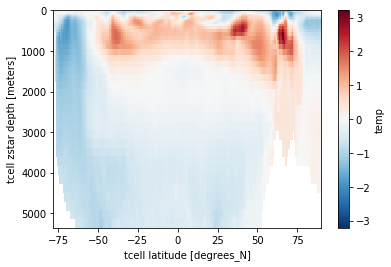

In [6]:
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

temp_10 = cc.get_nc_variable(expt, 'ocean.nc', 'temp',
                        chunks={'st_ocean': None}, n=n_files,
                        time_units=time_units, offset=offset).mean('time')
#temp_WOA13_10 = cc.get_nc_variable('woa13/10', 'woa13_ts_??_mom10.nc', 'temp').mean('time')
temp_WOA13_10 = cc.get_nc_variable('woa13/10_KDS50', 'ocean_temp_salt.res.nc', 'temp').mean('time')

# hacky renaming of variables so we can use as a dask array -- there's probably an elegant way to do this
temp_WOA13_10 = temp_WOA13_10.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
temp_WOA13_10['st_ocean'] = temp_10.st_ocean
temp_WOA13_10['xt_ocean'] = temp_10.xt_ocean
temp_WOA13_10['yt_ocean'] = temp_10.yt_ocean

temp_anom_10 = temp_10 - temp_WOA13_10 - 273.15
zonal_temp_anom_10 = temp_anom_10.mean('xt_ocean')
zonal_temp_anom_10.load()

IPython.display.clear_output()

zonal_temp_anom_10.plot(yincrease=False)

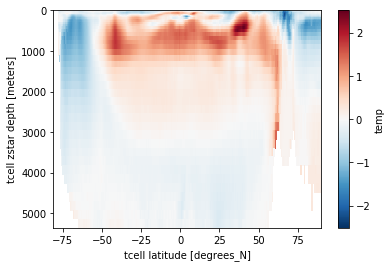

In [9]:
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

temp_025 = cc.get_nc_variable(expt, 'ocean.nc', 'temp',
                        chunks={'st_ocean': None}, n=n_files,
                        time_units=time_units, offset=offset).mean('time')

temp_WOA13_025 = cc.get_nc_variable('woa13/025_KDS50', 'woa13_ts_??_mom025.nc', 'temp').mean('time')
# hacky renaming of variables so we can use as a dask array -- there's probably an elegant way to do this
temp_WOA13_025 = temp_WOA13_025.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
temp_WOA13_025['st_ocean'] = temp_025.st_ocean
temp_WOA13_025['xt_ocean'] = temp_025.xt_ocean
temp_WOA13_025['yt_ocean'] = temp_025.yt_ocean

temp_anom_025 = temp_025 - temp_WOA13_025 - 273.15
zonal_temp_anom_025 = temp_anom_025.mean('xt_ocean')
zonal_temp_anom_025.load()

IPython.display.clear_output()

zonal_temp_anom_025.plot(yincrease=False)

In [11]:
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

chunks={'st_ocean':None, 'xt_ocean': 400, 'yt_ocean': 300}

temp_01 = cc.get_nc_variable(expt, 'ocean.nc', 'temp',
                        chunks=chunks, n=-12,
                        time_units=time_units, offset=offset).mean('time')

temp_WOA13_01 = cc.get_nc_variable('woa13/01', 'woa13_ts_??_mom01.nc', 'temp').mean('time')
# hacky renaming of variables so we can use as a dask array -- there's probably an elegant way to do this
temp_WOA13_01 = temp_WOA13_01.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
temp_WOA13_01['st_ocean'] = temp_01.st_ocean
temp_WOA13_01['xt_ocean'] = temp_01.xt_ocean
temp_WOA13_01['yt_ocean'] = temp_01.yt_ocean

# force calculation and save to disk 
temp_WOA13_01.to_netcdf('/local/g40/amh157/temp_woa13.nc')

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


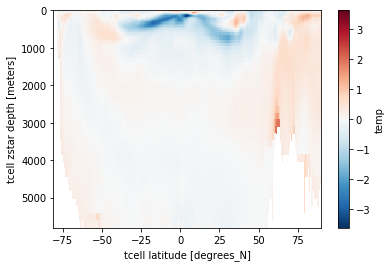

In [15]:
# rechunk to match ocean.nc data
temp_WOA13_01 = xr.open_dataset('/local/g40/amh157/temp_woa13.nc', chunks=chunks).temp
temp_WOA13_01 = temp_WOA13_01.astype(np.float32)

temp_anom_01 = temp_01 - temp_WOA13_01 - 273.15
zonal_temp_anom_01 = temp_anom_01.mean('xt_ocean')
zonal_temp_anom_01.load()

IPython.display.clear_output()

zonal_temp_anom_01.plot(yincrease=False)

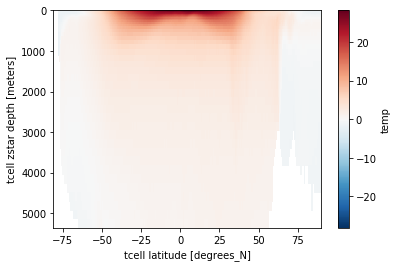

In [17]:
mask = temp_025.copy()
mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
temp_WOA13_025 = temp_WOA13_025*mask
zonal_temp_WOA13_025 = temp_WOA13_025.mean('xt_ocean')
zonal_temp_WOA13_025.load()

zonal_temp_WOA13_025.plot(yincrease=False)

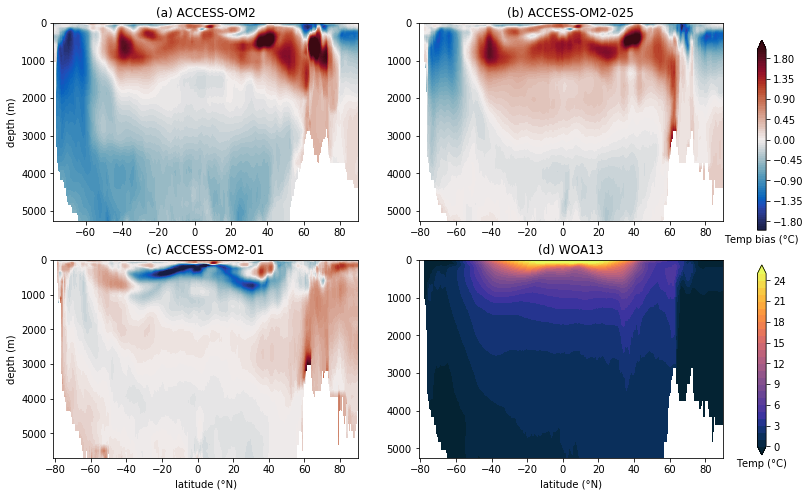

In [18]:
plt.figure(figsize=(12,8))
clev=np.arange(-2,2.01,0.05)
    
plt.subplot(221)
p1=zonal_temp_anom_10.plot.contourf(cmap=cm.cm.balance,levels=clev,yincrease=False,add_colorbar=False)
plt.xlabel('')
plt.ylabel('depth (m)')
plt.title('(a) ACCESS-OM2')

plt.subplot(222)
p2=zonal_temp_anom_025.plot.contourf(cmap=cm.cm.balance,levels=clev,yincrease=False,add_colorbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('(b) ACCESS-OM2-025')

plt.subplot(223)
p3=zonal_temp_anom_01.plot.contourf(cmap=cm.cm.balance,levels=clev,yincrease=False,add_colorbar=False)
plt.xlabel('latitude (°N)')
plt.ylabel('depth (m)')
plt.title('(c) ACCESS-OM2-01')

plt.subplot(224)
p4=zonal_temp_WOA13_025.plot.contourf(cmap=cm.cm.thermal,levels=np.arange(0,26,1),yincrease=False,add_colorbar=False)
plt.xlabel('latitude (°N)')
plt.ylabel('')
plt.title('(d) WOA13')

ax1 = plt.axes([0.94,0.52,0.01,0.33])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
#ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('Temp bias (°C)')


ax2 = plt.axes([0.94,0.13,0.01,0.33])
cb = plt.colorbar(p4,cax=ax2,orientation='vertical')
#ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('Temp (°C)')

savefigure('zonal_temp_bias')